In [ ]:
import math
from simtk import unit
from openmmtools import testsystems, states, mcmc, multistate
import os
import tempfile
import pickle
from perses.annihilation.lambda_protocol import RelativeAlchemicalState
import mdtraj as md
import numpy as np
from simtk.unit.quantity import Quantity
from matplotlib import pyplot as plt
from simtk.openmm import app
from openmmforcefields.generators import SystemGenerator
from perses.tests.test_topology_proposal import generate_atp, generate_dipeptide_top_pos_sys


In [ ]:

# Generate htf for capped ALA->THR in vacuum
atp, sys_gen = generate_atp()

# At alanine endstate
htf_0 = generate_dipeptide_top_pos_sys(atp.topology, 
                                         new_res = 'THR', 
                                         system = atp.system, 
                                         positions = atp.positions,
                                         system_generator = sys_gen, 
                                         conduct_htf_prop=True,
                                         repartitioned=True, endstate=0, validate_endstate_energy=False)

In [ ]:
# At threonine endstate
htf_1 = generate_dipeptide_top_pos_sys(atp.topology, 
                                         new_res = 'THR', 
                                         system = atp.system, 
                                         positions = atp.positions,
                                         system_generator = sys_gen, 
                                         conduct_htf_prop=True,
                                         repartitioned=True, endstate=1, validate_endstate_energy=False)

In [ ]:
def get_dihedrals(i, aa, length, out_dir, htf, dihedral_indices_new, dihedral_indices_old):
    new_top = md.Topology.from_openmm(htf._topology_proposal.new_topology)
    old_top = md.Topology.from_openmm(htf._topology_proposal.old_topology)
    
    # From Hannah: https://github.com/hannahbrucemacdonald/endstate_pdbs/blob/master/scripts/input_for_pol_calc.py
    from perses.analysis.utils import open_netcdf
    nc = open_netcdf(os.path.join(out_dir, f"{i}_vacuum_{aa}_{length}.nc"))
    nc_checkpoint = open_netcdf(os.path.join(out_dir, f"{i}_vacuum_{aa}_{length}_checkpoint.nc"))
    checkpoint_interval = nc_checkpoint.CheckpointInterval
    all_positions = nc_checkpoint.variables['positions']
    n_iter, n_replicas, n_atoms, _ = np.shape(all_positions)
    
    from tqdm import tqdm
    index = 0 # of replica
    all_pos_new = np.zeros(shape=(n_iter, new_top.n_atoms, 3))
    all_pos_old = np.zeros(shape=(n_iter, old_top.n_atoms, 3))
    all_pos_hybrid = np.zeros(shape=(n_iter, n_atoms, 3))
    for iteration in tqdm(range(n_iter)):
        replica_id = np.where(nc.variables['states'][iteration*checkpoint_interval] == index)[0]
        pos = all_positions[iteration,replica_id,:,:][0] *unit.nanometers
        all_pos_new[iteration] = htf.new_positions(pos).value_in_unit_system(unit.md_unit_system) # Get new positions only
        all_pos_hybrid[iteration] = pos.value_in_unit_system(unit.md_unit_system) # Get hybrid positions
        all_pos_old[iteration] = htf.old_positions(pos).value_in_unit_system(unit.md_unit_system)

    dihedrals_all = []
    # write for loop for this part -- old and new atoms
    for pos, top, indices in zip([all_pos_new, all_pos_old], [new_top, old_top], [dihedral_indices_new, dihedral_indices_old]):
        traj = md.Trajectory(np.array(pos), top)
        dihedrals = np.sin(md.compute_dihedrals(traj, np.array([indices]))) 
        dihedrals_all.append(dihedrals)
    return dihedrals_all[0], dihedrals_all[1], n_iter
        
def plot_dihedrals(dihedrals):
    # Plot histogram with error bars : https://stackoverflow.com/questions/35390276/how-to-add-error-bars-to-histogram-diagram-in-python
    entries, edges, _ = plt.hist(dihedrals)
    bin_centers = 0.5 * (edges[:-1] + edges[1:]) # calculate bin centers
    plt.errorbar(bin_centers, entries, yerr=np.sqrt(entries), fmt='r.') # draw errobars, use the sqrt error
    plt.xlim(-1, 1)
    plt.show()
    
def plot_time_series(dihedrals, n_iter):
    from perses.dispersed import feptasks
    t0, g, neff_max, a_t, uncorrelated_indices = feptasks.compute_timeseries(dihedrals)
    
    plt.scatter(range(n_iter), dihedrals)
    plt.ylabel("sin(dihedral)")
    plt.xlabel("iteration number")
    plt.show()
    
    return uncorrelated_indices
    
def plot_dihedrals_uncorrelated(dihedrals, uncorrelated_indices):
    # Plot histogram with error bars : https://stackoverflow.com/questions/35390276/how-to-add-error-bars-to-histogram-diagram-in-python
    entries, edges, _ = plt.hist(dihedrals[uncorrelated_indices])
    bin_centers = 0.5 * (edges[:-1] + edges[1:]) # calculate bin centers
    plt.errorbar(bin_centers, entries, yerr=np.sqrt(entries), fmt='r.') # draw errobars, use the sqrt error
    plt.xlim(-1, 1)
    plt.show()

THR->ALA htf

In [4]:
# Generate htf for capped THR->ALA in vacuum
pdb = app.PDBFile("../input/thr_vacuum.pdb")

forcefield_files = ['amber14/protein.ff14SB.xml', 'amber14/tip3p.xml']
barostat = None
system_generator = SystemGenerator(forcefields=forcefield_files,
                               barostat=barostat,
                               forcefield_kwargs={'removeCMMotion': False,
                                                    'ewaldErrorTolerance': 1e-4,
                                                    'constraints' : app.HBonds,
                                                    'hydrogenMass' : 4 * unit.amus},
                                periodic_forcefield_kwargs=None,
                                small_molecule_forcefield='gaff-2.11',
                                nonperiodic_forcefield_kwargs = {'nonbondedMethod': app.NoCutoff}, 
                                   molecules=None, 
                                   cache=None)
system = system_generator.create_system(pdb.topology) 
positions = unit.quantity.Quantity(value = np.array([list(atom_pos) for atom_pos in pdb.positions.value_in_unit_system(unit.md_unit_system)]), unit = unit.nanometers)

htf_0 = generate_dipeptide_top_pos_sys(pdb.topology, 
                                         new_res = 'ALA', 
                                         system = system, 
                                         positions = positions,
                                         system_generator = system_generator, 
                                         conduct_htf_prop=True,
                                         repartitioned=True, endstate=0, validate_endstate_energy=False)


DEBUG:perses.forcefields.system_generators:Trying GAFFTemplateGenerator to load gaff-2.11
INFO:proposal_generator:	Conducting polymer point mutation proposal...
INFO:proposal_generator:Using matching_criterion to chose best atom map
INFO:proposal_generator:Scaffold has symmetry of 0
INFO:proposal_generator:len [{4: 4, 7: 9}, {4: 4, 8: 9}, {4: 4, 9: 9}]
INFO:proposal_generator:{4: 4, 7: 9}
INFO:proposal_generator:{4: 4, 8: 9}
INFO:proposal_generator:{4: 4, 9: 9}
INFO:proposal_generator:Returning map that best satisfies matching_criterion
INFO:proposal_generator:Finding best map using matching_criterion name
INFO:proposal_generator:{4: 4, 7: 9}
INFO:geometry:propose: performing forward proposal
INFO:geometry:propose: unique new atoms detected; proceeding to _logp_propose...
INFO:geometry:Conducting forward proposal...
INFO:geometry:Computing proposal order with NetworkX...
INFO:geometry:number of atoms to be placed: 2
INFO:geometry:Atom index proposal order is [14, 15]
INFO:geometry:omit

making topology proposal
generating geometry engine
making geometry proposal from THR to ALA


INFO:geometry:creating platform, integrators, and contexts; setting growth parameter
INFO:geometry:setting atoms_with_positions context new positions
INFO:geometry:There are 2 new atoms
INFO:geometry:	reduced angle potential = 2.176976339432335.
INFO:geometry:	reduced angle potential = 0.4043243135475045.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 9 bond forces in the no-nonbonded final system
INFO:geometry:	there are 36 angle forces in the no-nonbonded final system
INFO:geometry:	there are 42 torsion forces in the no-nonbonded final system
INFO:geometry:forward final system defined with 0 neglected angles.


Desired platform not supported. exception raised: Error initializing CUDA: CUDA_ERROR_NO_DEVICE (100) at /opt/conda/conda-bld/openmm_1589508244174/work/platforms/cuda/src/CudaContext.cpp:148
conducting subsequent work with the following platform: CPU
Desired platform not supported. exception raised: Error initializing CUDA: CUDA_ERROR_NO_DEVICE (100) at /opt/conda/conda-bld/openmm_1589508244174/work/platforms/cuda/src/CudaContext.cpp:148
conducting subsequent work with the following platform: Reference
Desired platform not supported. exception raised: Error initializing CUDA: CUDA_ERROR_NO_DEVICE (100) at /opt/conda/conda-bld/openmm_1589508244174/work/platforms/cuda/src/CudaContext.cpp:148
conducting subsequent work with the following platform: Reference
Desired platform not supported. exception raised: Error initializing CUDA: CUDA_ERROR_NO_DEVICE (100) at /opt/conda/conda-bld/openmm_1589508244174/work/platforms/cuda/src/CudaContext.cpp:148
conducting subsequent work with the followin

INFO:geometry:total reduced potential before atom placement: 32.60026551580492
INFO:geometry:total reduced energy added from growth system: 17.300437049040198
INFO:geometry:final reduced energy 49.900702564845126
INFO:geometry:sum of energies: 49.90070256484512



Desired platform not supported. exception raised: Error initializing CUDA: CUDA_ERROR_NO_DEVICE (100) at /opt/conda/conda-bld/openmm_1589508244174/work/platforms/cuda/src/CudaContext.cpp:148
conducting subsequent work with the following platform: Reference
Desired platform not supported. exception raised: Error initializing CUDA: CUDA_ERROR_NO_DEVICE (100) at /opt/conda/conda-bld/openmm_1589508244174/work/platforms/cuda/src/CudaContext.cpp:148
conducting subsequent work with the following platform: Reference
Desired platform not supported. exception raised: Error initializing CUDA: CUDA_ERROR_NO_DEVICE (100) at /opt/conda/conda-bld/openmm_1589508244174/work/platforms/cuda/src/CudaContext.cpp:148
conducting subsequent work with the following platform: Reference
Desired platform not supported. exception raised: Error initializing CUDA: CUDA_ERROR_NO_DEVICE (100) at /opt/conda/conda-bld/openmm_1589508244174/work/platforms/cuda/src/CudaContext.cpp:148
conducting subsequent work with the f

INFO:geometry:magnitude of difference in the energies: 7.105427357601002e-15
INFO:geometry:Final logp_proposal: 7.48768218764739
INFO:geometry:logp_reverse: performing reverse proposal
INFO:geometry:logp_reverse: unique new atoms detected; proceeding to _logp_propose...
INFO:geometry:Conducting forward proposal...
INFO:geometry:Computing proposal order with NetworkX...
INFO:geometry:number of atoms to be placed: 6
INFO:geometry:Atom index proposal order is [18, 14, 15, 16, 17, 19]
INFO:geometry:omitted_bonds: []
INFO:geometry:direction of proposal is reverse; creating atoms_with_positions from old system/topology
INFO:geometry:creating growth system...
INFO:geometry:	creating bond force...
INFO:geometry:	there are 11 bonds in reference force.
INFO:geometry:	creating angle force...
INFO:geometry:	there are 43 angles in reference force.
INFO:geometry:	creating torsion force...
INFO:geometry:	creating extra torsions force...
INFO:geometry:	there are 72 torsions in reference force.
INFO:ge

Desired platform not supported. exception raised: Error initializing CUDA: CUDA_ERROR_NO_DEVICE (100) at /opt/conda/conda-bld/openmm_1589508244174/work/platforms/cuda/src/CudaContext.cpp:148
conducting subsequent work with the following platform: Reference
Desired platform not supported. exception raised: Error initializing CUDA: CUDA_ERROR_NO_DEVICE (100) at /opt/conda/conda-bld/openmm_1589508244174/work/platforms/cuda/src/CudaContext.cpp:148
conducting subsequent work with the following platform: Reference


INFO:geometry:reverse final system defined with 0 neglected angles.
INFO:geometry:total reduced potential before atom placement: 32.60026551580492


Desired platform not supported. exception raised: Error initializing CUDA: CUDA_ERROR_NO_DEVICE (100) at /opt/conda/conda-bld/openmm_1589508244174/work/platforms/cuda/src/CudaContext.cpp:148
conducting subsequent work with the following platform: Reference
Desired platform not supported. exception raised: Error initializing CUDA: CUDA_ERROR_NO_DEVICE (100) at /opt/conda/conda-bld/openmm_1589508244174/work/platforms/cuda/src/CudaContext.cpp:148
conducting subsequent work with the following platform: Reference
Desired platform not supported. exception raised: Error initializing CUDA: CUDA_ERROR_NO_DEVICE (100) at /opt/conda/conda-bld/openmm_1589508244174/work/platforms/cuda/src/CudaContext.cpp:148
conducting subsequent work with the following platform: Reference
Desired platform not supported. exception raised: Error initializing CUDA: CUDA_ERROR_NO_DEVICE (100) at /opt/conda/conda-bld/openmm_1589508244174/work/platforms/cuda/src/CudaContext.cpp:148
conducting subsequent work with the fo

INFO:geometry:total reduced energy added from growth system: 39.58155614123648
INFO:geometry:final reduced energy 72.1818216570414
INFO:geometry:sum of energies: 72.18182165704141
INFO:geometry:magnitude of difference in the energies: 7.105427357601002e-15
INFO:geometry:Final logp_proposal: -356.86646585368555
INFO:relative:Old system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:New system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:No unknown forces.
INFO:relative:Nonbonded method to be used (i.e. from old system): 0
INFO:relative:Adding and mapping old atoms to hybrid system...
INFO:relative:Adding and mapping new atoms to hybrid system...
INFO:relative:No MonteCarloBarostat added.
INFO:relative:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=2.0, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=2.0, z=0.

Desired platform not supported. exception raised: Error initializing CUDA: CUDA_ERROR_NO_DEVICE (100) at /opt/conda/conda-bld/openmm_1589508244174/work/platforms/cuda/src/CudaContext.cpp:148
conducting subsequent work with the following platform: Reference
added energy components: [('CustomBondForce', 1.1832308307824724), ('CustomAngleForce', 110.48068019382241), ('CustomTorsionForce', 10.60110316251282), ('CustomBondForce', -82.68345804588124)]


In [5]:
htf_1 = generate_dipeptide_top_pos_sys(pdb.topology, 
                                         new_res = 'ALA', 
                                         system = system, 
                                         positions = positions,
                                         system_generator = system_generator, 
                                         conduct_htf_prop=True,
                                         repartitioned=True, endstate=1, validate_endstate_energy=False)


INFO:proposal_generator:	Conducting polymer point mutation proposal...
INFO:proposal_generator:Using matching_criterion to chose best atom map
INFO:proposal_generator:Scaffold has symmetry of 0
INFO:proposal_generator:len [{4: 4, 7: 9}, {4: 4, 8: 9}, {4: 4, 9: 9}]
INFO:proposal_generator:{4: 4, 7: 9}
INFO:proposal_generator:{4: 4, 8: 9}
INFO:proposal_generator:{4: 4, 9: 9}
INFO:proposal_generator:Returning map that best satisfies matching_criterion
INFO:proposal_generator:Finding best map using matching_criterion name
INFO:proposal_generator:{4: 4, 7: 9}
INFO:geometry:propose: performing forward proposal
INFO:geometry:propose: unique new atoms detected; proceeding to _logp_propose...
INFO:geometry:Conducting forward proposal...
INFO:geometry:Computing proposal order with NetworkX...
INFO:geometry:number of atoms to be placed: 2
INFO:geometry:Atom index proposal order is [14, 15]
INFO:geometry:omitted_bonds: []
INFO:geometry:direction of proposal is forward; creating atoms_with_position

making topology proposal
generating geometry engine
making geometry proposal from THR to ALA


INFO:geometry:setting atoms_with_positions context new positions
INFO:geometry:There are 2 new atoms
INFO:geometry:	reduced angle potential = 0.12748423818816923.
INFO:geometry:	reduced angle potential = 1.503779968402172.


Desired platform not supported. exception raised: Error initializing CUDA: CUDA_ERROR_NO_DEVICE (100) at /opt/conda/conda-bld/openmm_1589508244174/work/platforms/cuda/src/CudaContext.cpp:148
conducting subsequent work with the following platform: Reference
Desired platform not supported. exception raised: Error initializing CUDA: CUDA_ERROR_NO_DEVICE (100) at /opt/conda/conda-bld/openmm_1589508244174/work/platforms/cuda/src/CudaContext.cpp:148
conducting subsequent work with the following platform: Reference


INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 9 bond forces in the no-nonbonded final system
INFO:geometry:	there are 36 angle forces in the no-nonbonded final system
INFO:geometry:	there are 42 torsion forces in the no-nonbonded final system
INFO:geometry:forward final system defined with 0 neglected angles.


Desired platform not supported. exception raised: Error initializing CUDA: CUDA_ERROR_NO_DEVICE (100) at /opt/conda/conda-bld/openmm_1589508244174/work/platforms/cuda/src/CudaContext.cpp:148
conducting subsequent work with the following platform: Reference
Desired platform not supported. exception raised: Error initializing CUDA: CUDA_ERROR_NO_DEVICE (100) at /opt/conda/conda-bld/openmm_1589508244174/work/platforms/cuda/src/CudaContext.cpp:148
conducting subsequent work with the following platform: Reference


INFO:geometry:total reduced potential before atom placement: 32.60026551580492
INFO:geometry:total reduced energy added from growth system: 21.092676389929256
INFO:geometry:final reduced energy 53.692941905734166
INFO:geometry:sum of energies: 53.69294190573417
INFO:geometry:magnitude of difference in the energies: 1.0658141036401503e-14
INFO:geometry:Final logp_proposal: 5.0531671729558765
INFO:geometry:logp_reverse: performing reverse proposal
INFO:geometry:logp_reverse: unique new atoms detected; proceeding to _logp_propose...
INFO:geometry:Conducting forward proposal...
INFO:geometry:Computing proposal order with NetworkX...
INFO:geometry:number of atoms to be placed: 6


Desired platform not supported. exception raised: Error initializing CUDA: CUDA_ERROR_NO_DEVICE (100) at /opt/conda/conda-bld/openmm_1589508244174/work/platforms/cuda/src/CudaContext.cpp:148
conducting subsequent work with the following platform: Reference
Desired platform not supported. exception raised: Error initializing CUDA: CUDA_ERROR_NO_DEVICE (100) at /opt/conda/conda-bld/openmm_1589508244174/work/platforms/cuda/src/CudaContext.cpp:148
conducting subsequent work with the following platform: Reference
Desired platform not supported. exception raised: Error initializing CUDA: CUDA_ERROR_NO_DEVICE (100) at /opt/conda/conda-bld/openmm_1589508244174/work/platforms/cuda/src/CudaContext.cpp:148
conducting subsequent work with the following platform: Reference
added energy components: [('CustomBondForce', 0.0), ('CustomAngleForce', 14.306221189239372), ('CustomTorsionForce', 0.697217802194598), ('CustomBondForce', 6.089237398495288)]


INFO:geometry:Atom index proposal order is [18, 14, 19, 15, 16, 17]
INFO:geometry:omitted_bonds: []
INFO:geometry:direction of proposal is reverse; creating atoms_with_positions from old system/topology
INFO:geometry:creating growth system...
INFO:geometry:	creating bond force...
INFO:geometry:	there are 11 bonds in reference force.
INFO:geometry:	creating angle force...
INFO:geometry:	there are 43 angles in reference force.
INFO:geometry:	creating torsion force...
INFO:geometry:	creating extra torsions force...
INFO:geometry:	there are 72 torsions in reference force.
INFO:geometry:	creating nonbonded force...
INFO:geometry:		grabbing reference nonbonded method, cutoff, switching function, switching distance...
INFO:geometry:		creating nonbonded exception force (i.e. custom bond for 1,4s)...
INFO:geometry:		looping through exceptions calculating growth indices, and adding appropriate interactions to custom bond force.
INFO:geometry:		there are 121 in the reference Nonbonded force
INFO:

Desired platform not supported. exception raised: Error initializing CUDA: CUDA_ERROR_NO_DEVICE (100) at /opt/conda/conda-bld/openmm_1589508244174/work/platforms/cuda/src/CudaContext.cpp:148
conducting subsequent work with the following platform: Reference


INFO:geometry:setting atoms_with_positions context old positions
INFO:geometry:There are 6 new atoms
INFO:geometry:	reduced angle potential = 0.9937847427445646.
INFO:geometry:	reduced angle potential = 0.0014854685245420216.
INFO:geometry:	reduced angle potential = 0.06574611719589983.
INFO:geometry:	reduced angle potential = 0.4119874609634221.
INFO:geometry:	reduced angle potential = 1.4721875889480596.
INFO:geometry:	reduced angle potential = 0.1309305042075324.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 11 bond forces in the no-nonbonded final system
INFO:geometry:	there are 43 angle forces in the no-nonbonded final system
INFO:geometry:	ther

Desired platform not supported. exception raised: Error initializing CUDA: CUDA_ERROR_NO_DEVICE (100) at /opt/conda/conda-bld/openmm_1589508244174/work/platforms/cuda/src/CudaContext.cpp:148
conducting subsequent work with the following platform: Reference
Desired platform not supported. exception raised: Error initializing CUDA: CUDA_ERROR_NO_DEVICE (100) at /opt/conda/conda-bld/openmm_1589508244174/work/platforms/cuda/src/CudaContext.cpp:148
conducting subsequent work with the following platform: Reference


INFO:geometry:total reduced potential before atom placement: 32.60026551580492
INFO:geometry:total reduced energy added from growth system: 39.58155614123648
INFO:geometry:final reduced energy 72.1818216570414
INFO:geometry:sum of energies: 72.18182165704141
INFO:geometry:magnitude of difference in the energies: 7.105427357601002e-15
INFO:geometry:Final logp_proposal: -360.4341867128945


Desired platform not supported. exception raised: Error initializing CUDA: CUDA_ERROR_NO_DEVICE (100) at /opt/conda/conda-bld/openmm_1589508244174/work/platforms/cuda/src/CudaContext.cpp:148
conducting subsequent work with the following platform: Reference
Desired platform not supported. exception raised: Error initializing CUDA: CUDA_ERROR_NO_DEVICE (100) at /opt/conda/conda-bld/openmm_1589508244174/work/platforms/cuda/src/CudaContext.cpp:148
conducting subsequent work with the following platform: Reference
Desired platform not supported. exception raised: Error initializing CUDA: CUDA_ERROR_NO_DEVICE (100) at /opt/conda/conda-bld/openmm_1589508244174/work/platforms/cuda/src/CudaContext.cpp:148
conducting subsequent work with the following platform: Reference
Desired platform not supported. exception raised: Error initializing CUDA: CUDA_ERROR_NO_DEVICE (100) at /opt/conda/conda-bld/openmm_1589508244174/work/platforms/cuda/src/CudaContext.cpp:148
conducting subsequent work with the fo

INFO:relative:Old system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:New system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:No unknown forces.
INFO:relative:Nonbonded method to be used (i.e. from old system): 0
INFO:relative:Adding and mapping old atoms to hybrid system...
INFO:relative:Adding and mapping new atoms to hybrid system...
INFO:relative:No MonteCarloBarostat added.
INFO:relative:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=2.0, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=2.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=2.0), unit=nanometer)]
INFO:relative:Determined atom classes.
INFO:relative:Generating old system exceptions dict...
INFO:relative:Generating new system exceptions dict...
INFO:relative:Handling constraints...
INFO:relative:Handling virtual sites...
INFO:

In [91]:
for i in range(htf_0.hybrid_system.getNumForces()):
    print(htf_0.hybrid_system.getForce(i))

<simtk.openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x2b5a7ff55ba0> >
<simtk.openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x2b5a7ff55ba0> >
<simtk.openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x2b5a7ff55ba0> >
<simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x2b5a7ff55ba0> >


In [87]:
hybrid_topology = htf_0._create_topology()
for i, atom in enumerate(hybrid_topology.atoms):
    print(i, atom)

0 ACE1-H1
1 ACE1-CH3
2 ACE1-H2
3 ACE1-H3
4 ACE1-C
5 ACE1-O
6 THR2-N
7 THR2-H
8 THR2-CA
9 THR2-HA
10 THR2-CB
11 THR2-C
12 THR2-O
13 THR2-HB
14 THR2-CG2
15 THR2-HG21
16 THR2-HG22
17 THR2-HG23
18 THR2-OG1
19 THR2-HG1
20 THR2-HB2
21 THR2-HB3
22 NME3-N
23 NME3-H
24 NME3-C
25 NME3-H1
26 NME3-H2
27 NME3-H3


In [81]:
# Plot torsion term
torsion_force = htf_0.hybrid_system.getForce(2)
for i in range(torsion_force.getNumTorsions()):
    print(torsion_force.getTorsionParameters(i))

[0, 1, 4, 5, 1, Quantity(value=0.0, unit=radian), Quantity(value=3.3472000000000004, unit=kilojoule/mole)]
[0, 1, 4, 5, 3, Quantity(value=3.141592653589793, unit=radian), Quantity(value=0.33472, unit=kilojoule/mole)]
[1, 4, 6, 7, 2, Quantity(value=3.141592653589793, unit=radian), Quantity(value=10.46, unit=kilojoule/mole)]
[1, 4, 6, 8, 2, Quantity(value=3.141592653589793, unit=radian), Quantity(value=10.46, unit=kilojoule/mole)]
[2, 1, 4, 5, 1, Quantity(value=0.0, unit=radian), Quantity(value=3.3472000000000004, unit=kilojoule/mole)]
[2, 1, 4, 5, 3, Quantity(value=3.141592653589793, unit=radian), Quantity(value=0.33472, unit=kilojoule/mole)]
[3, 1, 4, 5, 1, Quantity(value=0.0, unit=radian), Quantity(value=3.3472000000000004, unit=kilojoule/mole)]
[3, 1, 4, 5, 3, Quantity(value=3.141592653589793, unit=radian), Quantity(value=0.33472, unit=kilojoule/mole)]
[4, 6, 8, 10, 3, Quantity(value=0.0, unit=radian), Quantity(value=3.3472000000000004, unit=kilojoule/mole)]
[4, 6, 8, 10, 2, Quantity

In [88]:
0.5*k*(1-cos(n*theta-theta0))

AttributeError: type object 'object' has no attribute '__getattr__'

### NEW cache

In [6]:
i = 5
endstate = 1
aa = 'thr'
length = '5ns'
out_dir = f"/data/chodera/zhangi/perses_benchmark/neq/10/{i}/"

In [7]:
new_top = md.Topology.from_openmm(htf_1._topology_proposal.new_topology)

In [8]:
old_top = md.Topology.from_openmm(htf_1._topology_proposal.old_topology)

In [9]:
new_top.n_atoms

22

In [10]:
old_top.n_atoms

26

In [11]:
# From Hannah: https://github.com/hannahbrucemacdonald/endstate_pdbs/blob/master/scripts/input_for_pol_calc.py
from perses.analysis.utils import open_netcdf
nc = open_netcdf(os.path.join(out_dir, f"{i}_{endstate}_vacuum_{aa}_{length}.nc"))
nc_checkpoint = open_netcdf(os.path.join(out_dir, f"{i}_{endstate}_vacuum_{aa}_{length}_checkpoint.nc"))
checkpoint_interval = nc_checkpoint.CheckpointInterval
all_positions = nc_checkpoint.variables['positions']
n_iter, n_replicas, n_atoms, _ = np.shape(all_positions)

In [12]:
n_iter

5001

In [13]:
n_atoms

28

In [14]:
from tqdm import tqdm
index = 0 # of replica
all_pos = np.zeros(shape=(n_iter, 22, 3))
all_pos_old = np.zeros(shape=(n_iter, 26, 3))
all_pos_hybrid = np.zeros(shape=(n_iter, 28, 3))
for iteration in tqdm(range(n_iter)):
    replica_id = np.where(nc.variables['states'][iteration*checkpoint_interval] == index)[0]
    pos = all_positions[iteration,replica_id,:,:][0] *unit.nanometers
    all_pos[iteration] = htf_1.new_positions(pos).value_in_unit_system(unit.md_unit_system) # Get new positions only
    all_pos_hybrid[iteration] = pos.value_in_unit_system(unit.md_unit_system) # Get hybrid positions only
    all_pos_old[iteration] = htf_1.old_positions(pos).value_in_unit_system(unit.md_unit_system) # Get old positions only


100%|██████████| 5001/5001 [00:23<00:00, 208.44it/s]


In [15]:
np.array(all_pos).shape

(5001, 22, 3)

In [17]:
traj = md.Trajectory(np.array(all_pos), new_top)

In [18]:
for atom in traj.topology.atoms:
    print(atom, atom.index)

ACE1-H1 0
ACE1-CH3 1
ACE1-H2 2
ACE1-H3 3
ACE1-C 4
ACE1-O 5
ALA2-N 6
ALA2-H 7
ALA2-CA 8
ALA2-HA 9
ALA2-CB 10
ALA2-C 11
ALA2-O 12
ALA2-HB1 13
ALA2-HB2 14
ALA2-HB3 15
NME3-N 16
NME3-H 17
NME3-C 18
NME3-H1 19
NME3-H2 20
NME3-H3 21


In [14]:
traj.save(os.path.join(out_dir, f"{aa}_traj.pdb"))

In [19]:
# dihedrals = md.compute_dihedrals(traj, np.array([[9, 8, 10, 15]])) # mdtraj atom indices
# dihedrals = md.compute_dihedrals(traj, np.array([[10, 9, 11, 16]])) # pymol atom ID
# dihedrals = md.compute_dihedrals(traj, np.array([[14, 8, 11, 12]])) # pymol atom indices
# dihedrals = md.compute_dihedrals(traj, np.array([[9, 8, 11, 12]])) # indices used in analyze_correlation_times
# dihedrals = np.sin(md.compute_dihedrals(traj, np.array([[15, 10, 8, 6]]))) # SER -- from dominic (using mdtraj indices)
# dihedrals = np.sin(md.compute_dihedrals(traj, np.array([[18, 10, 8, 6]]))) # THR 
dihedrals = np.sin(md.compute_dihedrals(traj, np.array([[15, 10, 8, 6]]))) # from dominic (using mdtraj indices)

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplo

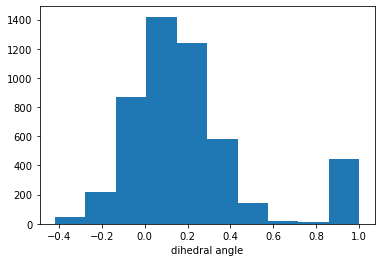

In [20]:
plt.hist(dihedrals)
plt.xlabel("dihedral angle")
plt.show()

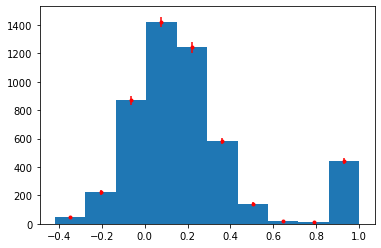

In [21]:
# with error bars : https://stackoverflow.com/questions/35390276/how-to-add-error-bars-to-histogram-diagram-in-python

entries, edges, _ = plt.hist(dihedrals)

# calculate bin centers
bin_centers = 0.5 * (edges[:-1] + edges[1:])

# draw errobars, use the sqrt error
plt.errorbar(bin_centers, entries, yerr=np.sqrt(entries), fmt='r.')

plt.show()

In [22]:
from perses.dispersed import feptasks
t0, g, neff_max, a_t, uncorrelated_indices = feptasks.compute_timeseries(dihedrals)

In [23]:
t0

41

In [24]:
uncorrelated_indices

[41,
 44,
 48,
 51,
 54,
 57,
 61,
 64,
 67,
 71,
 74,
 77,
 80,
 84,
 87,
 90,
 94,
 97,
 100,
 103,
 107,
 110,
 113,
 117,
 120,
 123,
 126,
 130,
 133,
 136,
 140,
 143,
 146,
 149,
 153,
 156,
 159,
 163,
 166,
 169,
 172,
 176,
 179,
 182,
 186,
 189,
 192,
 195,
 199,
 202,
 205,
 209,
 212,
 215,
 218,
 222,
 225,
 228,
 232,
 235,
 238,
 241,
 245,
 248,
 251,
 255,
 258,
 261,
 264,
 268,
 271,
 274,
 278,
 281,
 284,
 287,
 291,
 294,
 297,
 301,
 304,
 307,
 310,
 314,
 317,
 320,
 324,
 327,
 330,
 333,
 337,
 340,
 343,
 347,
 350,
 353,
 356,
 360,
 363,
 366,
 370,
 373,
 376,
 379,
 383,
 386,
 389,
 393,
 396,
 399,
 402,
 406,
 409,
 412,
 415,
 419,
 422,
 425,
 429,
 432,
 435,
 438,
 442,
 445,
 448,
 452,
 455,
 458,
 461,
 465,
 468,
 471,
 475,
 478,
 481,
 484,
 488,
 491,
 494,
 498,
 501,
 504,
 507,
 511,
 514,
 517,
 521,
 524,
 527,
 530,
 534,
 537,
 540,
 544,
 547,
 550,
 553,
 557,
 560,
 563,
 567,
 570,
 573,
 576,
 580,
 583,
 586,
 590,
 593,
 596

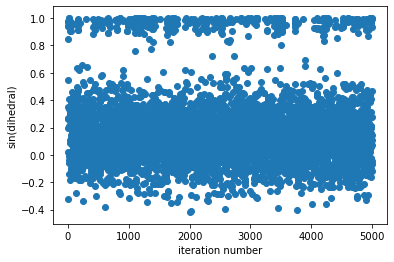

In [25]:
plt.scatter(range(n_iter), dihedrals)
plt.ylabel("sin(dihedral)")
plt.xlabel("iteration number")
plt.savefig(os.path.join(out_dir, f"{aa}_mixing.png"))
plt.show()

In [26]:
dihedrals[uncorrelated_indices].shape

(1510, 1)

In [27]:
neff_max

1510.1754

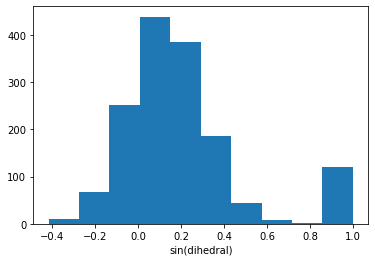

In [28]:
plt.hist(dihedrals[uncorrelated_indices])
plt.xlabel("sin(dihedral)")
plt.show()

In [24]:
snapshots = np.random.choice(uncorrelated_indices, size=200, replace=False)

In [25]:
snapshots.shape

(200,)

In [26]:
# Save snapshot indices and positions arrays
with open(os.path.join(out_dir, f"{aa}_indices.npy"), 'wb') as f:
    np.save(f, snapshots)
with open(os.path.join(out_dir, f"{aa}_pos_hybrid.npy"), 'wb') as f:
    np.save(f, all_pos_hybrid)
### NOTE: this should be old positions, not hybrid??

In [15]:
# with open(os.path.join(out_dir, f"ser_pos_hybrid.npy"), 'rb') as f:
#     ser_pos_hybrid = np.load(f)

In [179]:
# with open(os.path.join(out_dir, f"ala_pos_hybrid.npy"), 'rb') as f:
#     ala_pos_hybrid = np.load(f)

Plot dihedral distribution for old atoms

In [29]:
traj = md.Trajectory(np.array(all_pos_old), old_top)

In [30]:
for atom in traj.topology.atoms:
    print(atom, atom.index)

ACE1-H1 0
ACE1-CH3 1
ACE1-H2 2
ACE1-H3 3
ACE1-C 4
ACE1-O 5
THR2-N 6
THR2-H 7
THR2-CA 8
THR2-HA 9
THR2-CB 10
THR2-C 11
THR2-O 12
THR2-HB 13
THR2-CG2 14
THR2-HG21 15
THR2-HG22 16
THR2-HG23 17
THR2-OG1 18
THR2-HG1 19
NME3-N 20
NME3-H 21
NME3-C 22
NME3-H1 23
NME3-H2 24
NME3-H3 25


In [14]:
traj.save(os.path.join(out_dir, f"{aa}_traj.pdb"))

In [31]:
# dihedrals = md.compute_dihedrals(traj, np.array([[9, 8, 10, 15]])) # mdtraj atom indices
# dihedrals = md.compute_dihedrals(traj, np.array([[10, 9, 11, 16]])) # pymol atom ID
# dihedrals = md.compute_dihedrals(traj, np.array([[14, 8, 11, 12]])) # pymol atom indices
# dihedrals = md.compute_dihedrals(traj, np.array([[9, 8, 11, 12]])) # indices used in analyze_correlation_times
# dihedrals = np.sin(md.compute_dihedrals(traj, np.array([[15, 10, 8, 6]]))) # SER -- from dominic (using mdtraj indices)
dihedrals = np.sin(md.compute_dihedrals(traj, np.array([[18, 10, 8, 6]]))) # THR 
# dihedrals = np.sin(md.compute_dihedrals(traj, np.array([[15, 10, 8, 6]]))) # from dominic (using mdtraj indices)

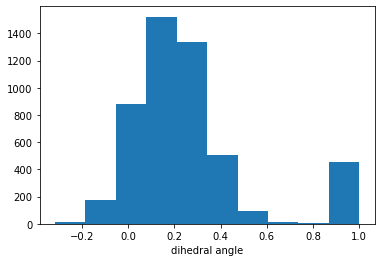

In [32]:
plt.hist(dihedrals)
plt.xlabel("dihedral angle")
plt.show()

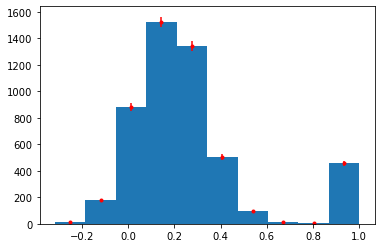

In [33]:
# with error bars : https://stackoverflow.com/questions/35390276/how-to-add-error-bars-to-histogram-diagram-in-python

entries, edges, _ = plt.hist(dihedrals)

# calculate bin centers
bin_centers = 0.5 * (edges[:-1] + edges[1:])

# draw errobars, use the sqrt error
plt.errorbar(bin_centers, entries, yerr=np.sqrt(entries), fmt='r.')

plt.show()

In [34]:
from perses.dispersed import feptasks
t0, g, neff_max, a_t, uncorrelated_indices = feptasks.compute_timeseries(dihedrals)

In [35]:
t0

1757

In [36]:
uncorrelated_indices

[1757,
 1760,
 1763,
 1766,
 1769,
 1772,
 1776,
 1779,
 1782,
 1785,
 1788,
 1791,
 1794,
 1797,
 1800,
 1803,
 1807,
 1810,
 1813,
 1816,
 1819,
 1822,
 1825,
 1828,
 1831,
 1834,
 1837,
 1841,
 1844,
 1847,
 1850,
 1853,
 1856,
 1859,
 1862,
 1865,
 1868,
 1872,
 1875,
 1878,
 1881,
 1884,
 1887,
 1890,
 1893,
 1896,
 1899,
 1902,
 1906,
 1909,
 1912,
 1915,
 1918,
 1921,
 1924,
 1927,
 1930,
 1933,
 1937,
 1940,
 1943,
 1946,
 1949,
 1952,
 1955,
 1958,
 1961,
 1964,
 1968,
 1971,
 1974,
 1977,
 1980,
 1983,
 1986,
 1989,
 1992,
 1995,
 1998,
 2002,
 2005,
 2008,
 2011,
 2014,
 2017,
 2020,
 2023,
 2026,
 2029,
 2033,
 2036,
 2039,
 2042,
 2045,
 2048,
 2051,
 2054,
 2057,
 2060,
 2063,
 2067,
 2070,
 2073,
 2076,
 2079,
 2082,
 2085,
 2088,
 2091,
 2094,
 2098,
 2101,
 2104,
 2107,
 2110,
 2113,
 2116,
 2119,
 2122,
 2125,
 2128,
 2132,
 2135,
 2138,
 2141,
 2144,
 2147,
 2150,
 2153,
 2156,
 2159,
 2163,
 2166,
 2169,
 2172,
 2175,
 2178,
 2181,
 2184,
 2187,
 2190,
 2193,
 2197,

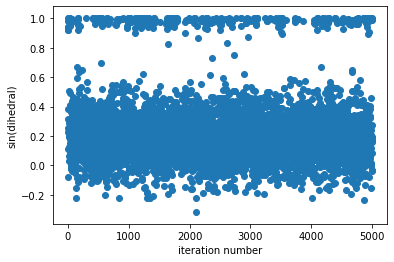

In [37]:
plt.scatter(range(n_iter), dihedrals)
plt.ylabel("sin(dihedral)")
plt.xlabel("iteration number")
plt.savefig(os.path.join(out_dir, f"{aa}_mixing.png"))
plt.show()

In [38]:
dihedrals[uncorrelated_indices].shape

(1048, 1)

In [39]:
neff_max

1048.2598

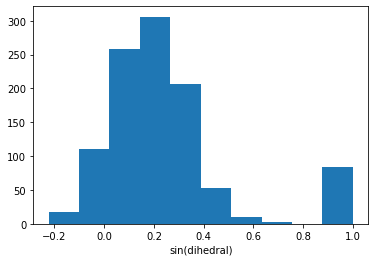

In [40]:
plt.hist(dihedrals[uncorrelated_indices])
plt.xlabel("sin(dihedral)")
plt.show()

### old cache

In [41]:
i = 5
endstate = 0
aa = 'thr'
length = '5ns'
out_dir = f"/data/chodera/zhangi/perses_benchmark/neq/10/{i}/"

In [42]:
old_top = md.Topology.from_openmm(htf_0._topology_proposal.old_topology)

In [43]:
new_top = md.Topology.from_openmm(htf_0._topology_proposal.new_topology)

In [44]:
old_top.n_atoms

26

In [45]:
new_top.n_atoms

22

In [46]:
# From Hannah: https://github.com/hannahbrucemacdonald/endstate_pdbs/blob/master/scripts/input_for_pol_calc.py
from perses.analysis.utils import open_netcdf
nc = open_netcdf(os.path.join(out_dir, f"{i}_{endstate}_vacuum_{aa}_{length}.nc"))
nc_checkpoint = open_netcdf(os.path.join(out_dir, f"{i}_{endstate}_vacuum_{aa}_{length}_checkpoint.nc"))
checkpoint_interval = nc_checkpoint.CheckpointInterval
all_positions = nc_checkpoint.variables['positions']
n_iter, n_replicas, n_atoms, _ = np.shape(all_positions)

In [47]:
n_iter

5001

In [48]:
n_atoms

28

In [49]:
from tqdm import tqdm
index = 0 # of replica
all_pos = np.zeros(shape=(n_iter, 26, 3))
all_pos_new = np.zeros(shape=(n_iter, 22, 3))
all_pos_hybrid = np.zeros(shape=(n_iter, 28, 3))
for iteration in tqdm(range(n_iter)):
    replica_id = np.where(nc.variables['states'][iteration*checkpoint_interval] == index)[0]
    pos = all_positions[iteration,replica_id,:,:][0] *unit.nanometers
    all_pos[iteration] = htf_0.old_positions(pos).value_in_unit_system(unit.md_unit_system) # Get old positions only
    all_pos_hybrid[iteration] = pos.value_in_unit_system(unit.md_unit_system) # Get hybrid positions only
    all_pos_new[iteration] = htf_0.new_positions(pos).value_in_unit_system(unit.md_unit_system) # Get new positions only


100%|██████████| 5001/5001 [00:23<00:00, 208.77it/s]


In [50]:
np.array(all_pos).shape

(5001, 26, 3)

In [51]:
traj = md.Trajectory(np.array(all_pos), old_top)

In [37]:
traj.save(os.path.join(out_dir, f"{aa}_traj.pdb"))

In [52]:
for atom in old_top.atoms:
    print(atom, atom.index)

ACE1-H1 0
ACE1-CH3 1
ACE1-H2 2
ACE1-H3 3
ACE1-C 4
ACE1-O 5
THR2-N 6
THR2-H 7
THR2-CA 8
THR2-HA 9
THR2-CB 10
THR2-C 11
THR2-O 12
THR2-HB 13
THR2-CG2 14
THR2-HG21 15
THR2-HG22 16
THR2-HG23 17
THR2-OG1 18
THR2-HG1 19
NME3-N 20
NME3-H 21
NME3-C 22
NME3-H1 23
NME3-H2 24
NME3-H3 25


In [53]:
# dihedrals = md.compute_dihedrals(traj, np.array([[9, 8, 10, 15]])) # mdtraj atom indices
# dihedrals = md.compute_dihedrals(traj, np.array([[10, 9, 11, 16]])) # pymol atom ID
# dihedrals = md.compute_dihedrals(traj, np.array([[14, 8, 11, 12]])) # pymol atom indices
# dihedrals = md.compute_dihedrals(traj, np.array([[9, 8, 11, 12]])) # indices used in analyze_correlation_times
# dihedrals = np.sin(md.compute_dihedrals(traj, np.array([[15, 10, 8, 6]]))) # ALA -- from dominic (using mdtraj indices)
dihedrals = np.sin(md.compute_dihedrals(traj, np.array([[18, 10, 8, 6]]))) # THR 


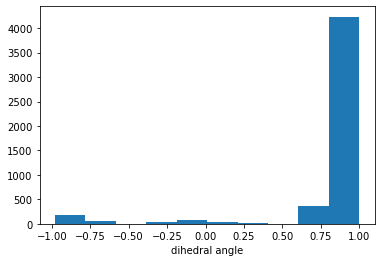

In [54]:
plt.hist(dihedrals)
plt.xlabel("dihedral angle")
plt.show()

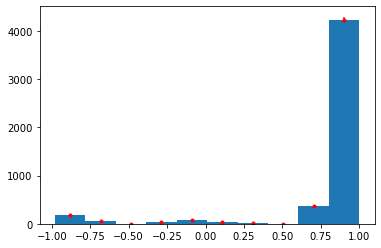

In [55]:
# with error bars : https://stackoverflow.com/questions/35390276/how-to-add-error-bars-to-histogram-diagram-in-python

entries, edges, _ = plt.hist(dihedrals)

# calculate bin centers
bin_centers = 0.5 * (edges[:-1] + edges[1:])

# draw errobars, use the sqrt error
plt.errorbar(bin_centers, entries, yerr=np.sqrt(entries), fmt='r.')

plt.show()

In [56]:
from perses.dispersed import feptasks
t0, g, neff_max, a_t, uncorrelated_indices = feptasks.compute_timeseries(dihedrals)

In [57]:
uncorrelated_indices

[1781,
 1783,
 1785,
 1788,
 1790,
 1792,
 1794,
 1797,
 1799,
 1801,
 1803,
 1806,
 1808,
 1810,
 1812,
 1815,
 1817,
 1819,
 1821,
 1824,
 1826,
 1828,
 1830,
 1833,
 1835,
 1837,
 1839,
 1842,
 1844,
 1846,
 1848,
 1851,
 1853,
 1855,
 1857,
 1860,
 1862,
 1864,
 1866,
 1868,
 1871,
 1873,
 1875,
 1877,
 1880,
 1882,
 1884,
 1886,
 1889,
 1891,
 1893,
 1895,
 1898,
 1900,
 1902,
 1904,
 1907,
 1909,
 1911,
 1913,
 1916,
 1918,
 1920,
 1922,
 1925,
 1927,
 1929,
 1931,
 1934,
 1936,
 1938,
 1940,
 1942,
 1945,
 1947,
 1949,
 1951,
 1954,
 1956,
 1958,
 1960,
 1963,
 1965,
 1967,
 1969,
 1972,
 1974,
 1976,
 1978,
 1981,
 1983,
 1985,
 1987,
 1990,
 1992,
 1994,
 1996,
 1999,
 2001,
 2003,
 2005,
 2008,
 2010,
 2012,
 2014,
 2017,
 2019,
 2021,
 2023,
 2025,
 2028,
 2030,
 2032,
 2034,
 2037,
 2039,
 2041,
 2043,
 2046,
 2048,
 2050,
 2052,
 2055,
 2057,
 2059,
 2061,
 2064,
 2066,
 2068,
 2070,
 2073,
 2075,
 2077,
 2079,
 2082,
 2084,
 2086,
 2088,
 2091,
 2093,
 2095,
 2097,
 2100,

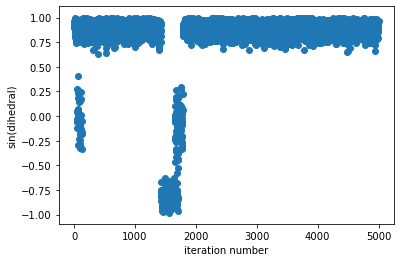

In [58]:
plt.scatter(range(n_iter), dihedrals)
plt.ylabel("sin(dihedral)")
plt.xlabel("iteration number")
plt.savefig(os.path.join(out_dir, f"{aa}_mixing.png"))
plt.show()

In [59]:
dihedrals[uncorrelated_indices].shape

(1436, 1)

In [60]:
neff_max

1435.9879

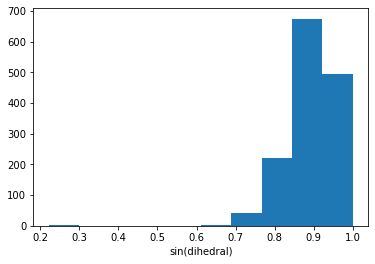

In [61]:
plt.hist(dihedrals[uncorrelated_indices])
plt.xlabel("sin(dihedral)")
plt.show()

In [25]:
snapshots = np.random.choice(uncorrelated_indices, size=200, replace=False)


In [27]:
# Save snapshot indices and positions arrays
with open(os.path.join(out_dir, f"{aa}_indices.npy"), 'wb') as f:
    np.save(f, snapshots)
with open(os.path.join(out_dir, f"{aa}_pos.npy"), 'wb') as f:
    np.save(f, all_pos)

In [8]:
with open(os.path.join(out_dir, f"{'thr'}_indices.npy"), 'rb') as f:
    snapshots = np.load(f)

with open(os.path.join(out_dir, f"{aa}_pos.npy"), 'rb') as f:
    all_pos = np.load(f)

In [9]:
traj = md.Trajectory(np.array(all_pos[snapshots]), old_top)

In [10]:
traj.save("t_repex.pdb")

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplo

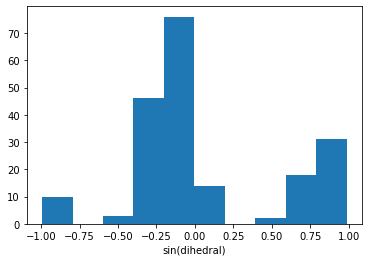

In [18]:
plt.hist(dihedrals[snapshots])
plt.xlabel("sin(dihedral)")
plt.show()

Plot dihedral distributions of new atoms

In [62]:
traj = md.Trajectory(np.array(all_pos_new), new_top)

In [63]:
traj.save(os.path.join(out_dir, f"{aa}_traj.pdb"))

In [64]:
for atom in new_top.atoms:
    print(atom, atom.index)

ACE1-H1 0
ACE1-CH3 1
ACE1-H2 2
ACE1-H3 3
ACE1-C 4
ACE1-O 5
ALA2-N 6
ALA2-H 7
ALA2-CA 8
ALA2-HA 9
ALA2-CB 10
ALA2-C 11
ALA2-O 12
ALA2-HB1 13
ALA2-HB2 14
ALA2-HB3 15
NME3-N 16
NME3-H 17
NME3-C 18
NME3-H1 19
NME3-H2 20
NME3-H3 21


In [65]:
# dihedrals = md.compute_dihedrals(traj, np.array([[9, 8, 10, 15]])) # mdtraj atom indices
# dihedrals = md.compute_dihedrals(traj, np.array([[10, 9, 11, 16]])) # pymol atom ID
# dihedrals = md.compute_dihedrals(traj, np.array([[14, 8, 11, 12]])) # pymol atom indices
# dihedrals = md.compute_dihedrals(traj, np.array([[9, 8, 11, 12]])) # indices used in analyze_correlation_times
dihedrals = np.sin(md.compute_dihedrals(traj, np.array([[15, 10, 8, 6]]))) # ALA -- from dominic (using mdtraj indices)
# dihedrals = np.sin(md.compute_dihedrals(traj, np.array([[18, 10, 8, 6]]))) # THR 


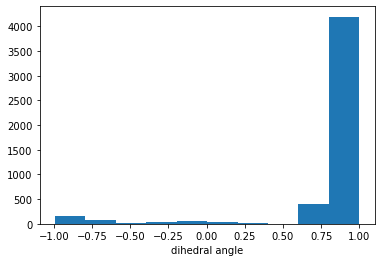

In [66]:
plt.hist(dihedrals)
plt.xlabel("dihedral angle")
plt.show()

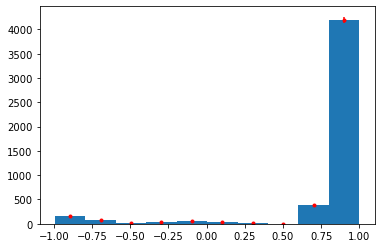

In [67]:
# with error bars : https://stackoverflow.com/questions/35390276/how-to-add-error-bars-to-histogram-diagram-in-python

entries, edges, _ = plt.hist(dihedrals)

# calculate bin centers
bin_centers = 0.5 * (edges[:-1] + edges[1:])

# draw errobars, use the sqrt error
plt.errorbar(bin_centers, entries, yerr=np.sqrt(entries), fmt='r.')

plt.show()

In [68]:
from perses.dispersed import feptasks
t0, g, neff_max, a_t, uncorrelated_indices = feptasks.compute_timeseries(dihedrals)

In [69]:
uncorrelated_indices

[1781,
 1783,
 1785,
 1788,
 1790,
 1792,
 1794,
 1796,
 1798,
 1801,
 1803,
 1805,
 1807,
 1809,
 1812,
 1814,
 1816,
 1818,
 1820,
 1822,
 1825,
 1827,
 1829,
 1831,
 1833,
 1835,
 1838,
 1840,
 1842,
 1844,
 1846,
 1849,
 1851,
 1853,
 1855,
 1857,
 1859,
 1862,
 1864,
 1866,
 1868,
 1870,
 1873,
 1875,
 1877,
 1879,
 1881,
 1883,
 1886,
 1888,
 1890,
 1892,
 1894,
 1897,
 1899,
 1901,
 1903,
 1905,
 1907,
 1910,
 1912,
 1914,
 1916,
 1918,
 1920,
 1923,
 1925,
 1927,
 1929,
 1931,
 1934,
 1936,
 1938,
 1940,
 1942,
 1944,
 1947,
 1949,
 1951,
 1953,
 1955,
 1958,
 1960,
 1962,
 1964,
 1966,
 1968,
 1971,
 1973,
 1975,
 1977,
 1979,
 1981,
 1984,
 1986,
 1988,
 1990,
 1992,
 1995,
 1997,
 1999,
 2001,
 2003,
 2005,
 2008,
 2010,
 2012,
 2014,
 2016,
 2019,
 2021,
 2023,
 2025,
 2027,
 2029,
 2032,
 2034,
 2036,
 2038,
 2040,
 2043,
 2045,
 2047,
 2049,
 2051,
 2053,
 2056,
 2058,
 2060,
 2062,
 2064,
 2066,
 2069,
 2071,
 2073,
 2075,
 2077,
 2080,
 2082,
 2084,
 2086,
 2088,
 2090,

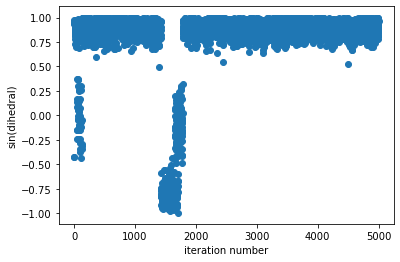

In [70]:
plt.scatter(range(n_iter), dihedrals)
plt.ylabel("sin(dihedral)")
plt.xlabel("iteration number")
plt.savefig(os.path.join(out_dir, f"{aa}_mixing.png"))
plt.show()

In [71]:
dihedrals[uncorrelated_indices].shape

(1478, 1)

In [72]:
neff_max

1477.9989

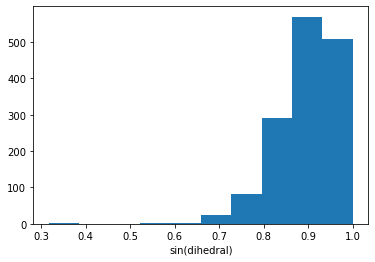

In [73]:
plt.hist(dihedrals[uncorrelated_indices])
plt.xlabel("sin(dihedral)")
plt.show()